
# Data loading

In [75]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy.random as rand
from scipy import stats
from sklearn import preprocessing 

import re
import json

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from AutoClean import AutoClean

warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv('./source_data/airbnb.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Bathrooms                                           999 non-null    int64  
 1   Bedrooms                                            999 non-null    int64  
 2   Beds                                                999 non-null    int64  
 3   LocationName                                        999 non-null    object 
 4   NumGuests                                           999 non-null    int64  
 5   NumReviews                                          999 non-null    int64  
 6   Price                                               999 non-null    int64  
 7   Rating                                              999 non-null    object 
 8   zipcode                                             999 non-null    int64  
 9  

# Data exploration

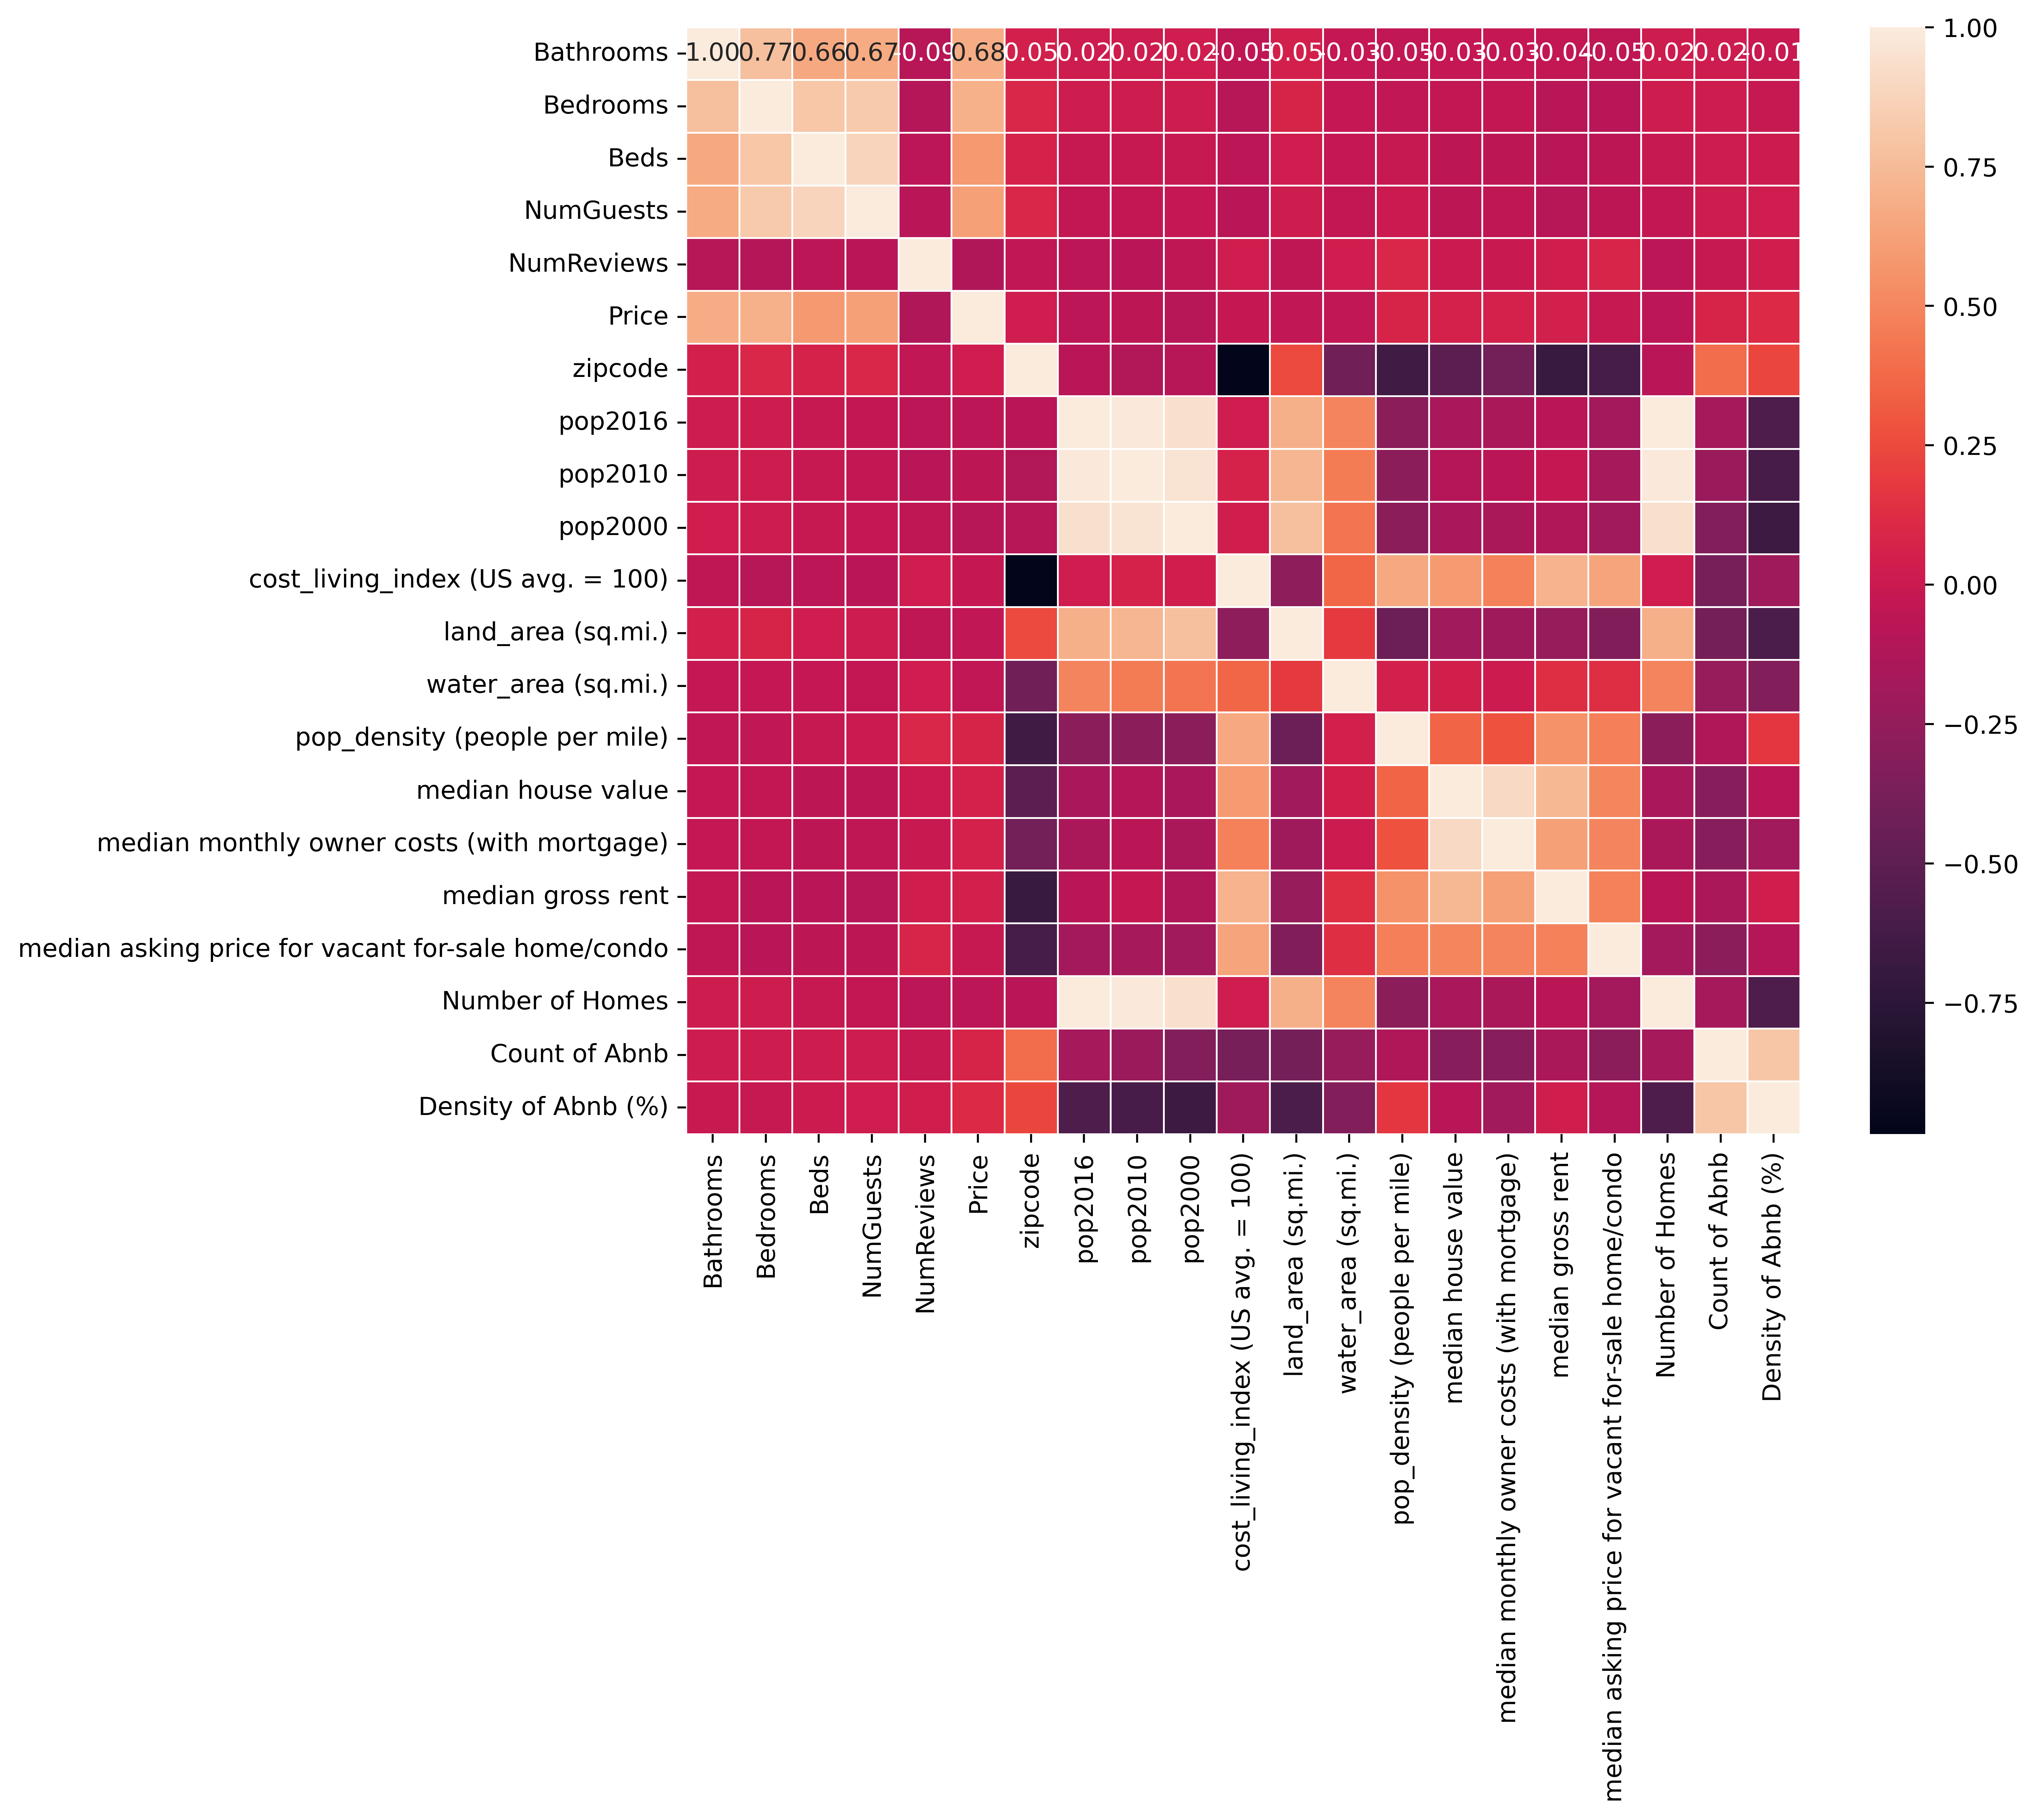

In [4]:
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(data.corr(method='pearson'),annot=True,fmt=".2f", linewidth=.5)
plt.show()

In [5]:
data.isnull().sum()

Bathrooms                                             0
Bedrooms                                              0
Beds                                                  0
LocationName                                          0
NumGuests                                             0
NumReviews                                            0
Price                                                 0
Rating                                                0
zipcode                                               0
pop2016                                               0
pop2010                                               0
pop2000                                               0
cost_living_index (US avg. = 100)                     0
land_area (sq.mi.)                                    0
water_area (sq.mi.)                                   0
pop_density (people per mile)                         0
median house value                                    0
median monthly owner costs (with mortgage)      

In [6]:
new_columns = []
for column in data.columns:
    new_col = re.sub("[()%=.-/]", '', column)
    new_col = new_col.replace(' ', '_')
    if new_col[-1] == '_':
        new_col = new_col[:-1]

    #print(column + " -> " + new_col)
    data.rename(columns={column: new_col}, inplace=True)

# replacing values
label_encoder = preprocessing.LabelEncoder() 
data['Rating']= label_encoder.fit_transform(data['Rating']) 
data['LocationName']= label_encoder.fit_transform(data['LocationName']) 

data.info()
data.to_csv('./airbnb_trim.csv', index=False, sep=',')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Bathrooms                                          999 non-null    int64  
 1   Bedrooms                                           999 non-null    int64  
 2   Beds                                               999 non-null    int64  
 3   LocationName                                       999 non-null    int64  
 4   NumGuests                                          999 non-null    int64  
 5   NumReviews                                         999 non-null    int64  
 6   Price                                              999 non-null    int64  
 7   Rating                                             999 non-null    int64  
 8   zipcode                                            999 non-null    int64  
 9   pop2016   

In [7]:
# Split data into training and testing sets
X = data.drop("Rating", axis=1)  # Features
y = data["Rating"]  # Target variable

# Starting Model

In [8]:
# Splitting dataset
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2)

In [9]:
# Define the parameter grid for GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [4, 8, 16],  # Maximum depth of each tree
    "min_samples_split": [2, 5, 10],  # Minimum number of samples to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum number of samples in each leaf
    "max_features": ["sqrt", "log2"],
    "random_state": [0, 100, 1000]
}

# Create the GridSearchCV object
model = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring="accuracy")

# Fit the model to the training data
model.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params = model.best_params_
best_score = model.best_score_


print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

Best Hyperparameters: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 1000}
Best Score: 0.7697012578616352


In [10]:
# Building Model
best_params = {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 1000}
clf = RandomForestClassifier(**best_params)

# Training the model on the training dataset
clf.fit(X_train, y_train)

# performing predictions
y_pred = clf.predict(X_test)
accuracy=metrics.accuracy_score(y_test,y_pred)
report=classification_report(y_test,y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.07      0.13        40
           1       0.81      0.97      0.88       160

    accuracy                           0.80       200
   macro avg       0.62      0.53      0.51       200
weighted avg       0.73      0.80      0.73       200



# Make data dirty

### Adding Outliers Values

In [ ]:
def add_outliers(df, outlier_percent):
    """
    Changes a specified percentage of values in a DataFrame to values outside the 
    existing feature range.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        outlier_percent (float): The percentage of values to change (0.0 to 1.0).

    Returns:
        pandas.DataFrame: The modified DataFrame with outliers introduced.
    """

    if outlier_percent < 0 or outlier_percent > 1:
        raise ValueError("outlier_percent must be between 0 and 1")

    # Create a mask with True for values to change
    outlier_mask = rand.rand(df.shape[0], df.shape[1]) < outlier_percent
    df_outliers = df.copy()

    for col in df.columns:
        # Get minimum and maximum values (excluding potential existing outliers)
        min_val = df.min(axis=0)[col]
        max_val = df.max(axis=0)[col]

        # Generate random values outside the range for outliers
        df_outliers[col] = [rand.uniform((min_val*0.3)-df.loc[i, col], (max_val*0.3)-df.loc[i, col]) for i in range(df.shape[0])]

    
    df_outliers = df_outliers * outlier_mask

    return df + df_outliers

### Change distribution

In [ ]:
def add_gaussian_noise(df, noise_percent):
  """
  Adds Gaussian noise to specified columns in a DataFrame for a given percentage.

  Args:
      df (pandas.DataFrame): The input DataFrame.
      noise_percent (float): The percentage of standard deviation to add as noise (0.0 to 1.0).
      columns (list): A list of column names to add noise to.

  Returns:
      pandas.DataFrame: The modified DataFrame with Gaussian noise added.
  """

  if noise_percent < 0 or noise_percent > 1:
    raise ValueError("noise_percent must be between 0.0 and 1.0")

# Create a mask with True for values to change
  outlier_mask = rand.rand(df.shape[0], df.shape[1]) < noise_percent
  df_gauss = df.copy()

  for col in df_gauss.columns:
    # Get standard deviation for noise based on percentage
    std_dev = df_gauss[col].std() * noise_percent


    gaussian_noise = np.random.normal(0, std_dev, df_gauss.shape[0])
    df_gauss[col] = df_gauss[col] + gaussian_noise

  
  df_gauss = df_gauss * outlier_mask

  return df + df_gauss


### Adding Missing Values

In [ ]:
def add_missing_values(df, missing_percent):
    """
    Adds missing values randomly to a DataFrame for a specified percentage.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        missing_percent (float): The percentage of missing values to add (0.0 to 1.0).

    Returns:
        pandas.DataFrame: The modified DataFrame with missing values added.
    """

    if missing_percent < 0 or missing_percent > 1:
        raise ValueError("missing_percent must be between 0 and 1")

    # Create a mask with True for missing values based on the percentage
    missing_mask = np.random.rand(df.shape[0], df.shape[1]) < missing_percent

    # Replace existing values with NaN based on the mask
    df_with_missing = df.where(~missing_mask, np.NAN)

    return df_with_missing


### Creating dirty data

In [ ]:
# 10, 20, 30 percent of data missing
dirty_data_10 = add_outliers(data.copy(), 0.04)
dirty_data_10 = add_gaussian_noise(dirty_data_10, 0.03)
dirty_data_10 = add_missing_values(dirty_data_10, 0.04)

dirty_data_20 = add_outliers(data.copy(), 0.07)
dirty_data_20 = add_gaussian_noise(dirty_data_20, 0.07)
dirty_data_20 = add_missing_values(dirty_data_20, 0.08)

dirty_data_30 = add_outliers(data.copy(), 0.12)
dirty_data_30 = add_gaussian_noise(dirty_data_30, 0.1)
dirty_data_30 = add_missing_values(dirty_data_30, 0.12)

# Salving
dirty_data_10.to_csv('./dirty_data/dirty_data_10.csv', index=False, sep=',')
dirty_data_20.to_csv('./dirty_data/dirty_data_20.csv', index=False, sep=',')
dirty_data_30.to_csv('./dirty_data/dirty_data_30.csv', index=False, sep=',')

In [ ]:
differences = data.count().sum() - (data == dirty_data_10).astype(int).sum().sum()
total_val = data.shape[0]*data.shape[1]
print("dirty_data_10:")
print(f"Different values: {differences} out of {total_val}")
print(f"Percentage: {round((differences*100)/total_val, 2)}%")
print()

differences = data.count().sum() - (data == dirty_data_20).astype(int).sum().sum()
print("dirty_data_20:")
print(f"Different values: {differences} out of {total_val}")
print(f"Percentage: {round((differences*100)/total_val, 2)}%")
print()

differences = data.count().sum() - (data == dirty_data_30).astype(int).sum().sum()
print("dirty_data_30:")
print(f"Different values: {differences} out of {total_val}")
print(f"Percentage: {round((differences*100)/total_val, 2)}%")
print()

# Cleaning data

## Manual cleaning

## 10%

In [66]:
dirty_data = pd.read_csv('./dirty_data/dirty_data_10.csv')
dirty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Bathrooms                                          968 non-null    float64
 1   Bedrooms                                           958 non-null    float64
 2   Beds                                               965 non-null    float64
 3   LocationName                                       968 non-null    float64
 4   NumGuests                                          968 non-null    float64
 5   NumReviews                                         964 non-null    float64
 6   Price                                              957 non-null    float64
 7   Rating                                             961 non-null    float64
 8   zipcode                                            960 non-null    float64
 9   pop2016   

In [53]:
# handle missing values
def remove_missing(dirty_data, MODE='mean'):
    print(f"Null data before:  {dirty_data.isna().any().sum()}")

    if dirty_data.isna().any().sum() > 0:
        if MODE == 'mean':
            for column in dirty_data.columns:
                if dirty_data[column].isnull().values.any():
                    dirty_data[column].fillna(float(dirty_data[column].mean()), inplace=True)
        elif MODE == 'delete':
            dirty_data.dropna(inplace=True)
        elif MODE == 'zeros':
            dirty_data.fillna(0, inplace=True)

        print(f"Null data after:  {dirty_data.isna().any().sum()}")

In [68]:
# remove outliers
def remove_outliers(dirty_data, threshold_z=2):
    print("Original Dataframe shape:", dirty_data.shape)
    for column in dirty_data.columns:
        z = np.abs(stats.zscore(dirty_data[column]))

        outlier_indices = np.where(z > threshold_z)[0]
        no_outliers = dirty_data.drop(outlier_indices)
    
    print("Dataframe shape after removing outliers:", no_outliers.shape)


In [72]:
def encode_y(data):
    label_encoder = preprocessing.LabelEncoder() 
    data['Rating']= label_encoder.fit_transform(data['Rating']) 

    y = data['Rating']
    y_mean = data['Rating'].mean()
    for i in range(len(y)):
        if y[i] >= y_mean:
            y[i]=1
        else:
            y[i]=0

    return y

In [69]:
remove_missing(dirty_data)
remove_outliers(dirty_data)

Null data before:  0
Original Dataframe shape: (999, 23)
Dataframe shape after removing outliers: (986, 23)


In [74]:
# Split data into training and testing sets
X = dirty_data.drop("Rating", axis=1)  # Features
y = encode_y(dirty_data)

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Building Model
best_params = {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 1000}
clf = RandomForestClassifier(**best_params)

# Training the model on the training dataset
clf.fit(X_train, y_train)

# performing predictions
y_pred = clf.predict(X_test)
accuracy=metrics.accuracy_score(y_test,y_pred)
report=classification_report(y_test,y_pred)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.06      0.11        47
           1       0.77      0.97      0.86       153

    accuracy                           0.76       200
   macro avg       0.57      0.52      0.48       200
weighted avg       0.68      0.76      0.68       200



## HoloClean
https://github.com/HoloClean/holoclean/tree/master

Conda environment: holoclean37

With Holoclean the results are stored as table in Postgresql, it also allow to evaluate result if you give it a clean dataset

python holoclean/examples/holoclean_reapair_airbnb.py [database list]

In [11]:
def load_data(path):
    path = './clean_data/HoloClean/' + path
    return pd.read_csv(path)

def get_differences(hc_data):
    # Differences between clean data and source data
    differences = data.count().sum() - (data == hc_data).astype(int).sum().sum()
    total_val = data.shape[0]*data.shape[1]
    print(f"Different values: {differences} out of {total_val}")
    print(f"Percentage: {round((differences*100)/total_val, 2)}%")
    print(f"Null data:  {hc_data.isna().any().sum()}")

def manage_nan(hc_data, DELETE=False):
    # Replace NaN values
    if DELETE:
        hc_data.dropna(inplace=True)

    else:
        for column in hc_data.columns:
            if hc_data[column].isnull().values.any():
                hc_data[column].fillna(float(hc_data[column].mean()), inplace=True)

    print(f"Null data:  {hc_data.isna().any().sum()}")

In [12]:
def make_split(hc_data):
    # Encoding rating
    label_encoder = preprocessing.LabelEncoder() 
    hc_data['Rating']= label_encoder.fit_transform(hc_data['Rating']) 

    # Split data into training and testing sets
    X = hc_data.drop("Rating", axis=1)  # Features
    y = hc_data["Rating"]  # Target variable

    y_mean = hc_data['Rating'].mean()
    for i in range(len(y)):
        if y[i] >= y_mean:
            y[i]=1
        else:
            y[i]=0

    # Splitting dataset
    return train_test_split(X, y, test_size=0.2)

def train_model(X_train, X_test, y_train, y_test):
    # Building Model
    clf = RandomForestClassifier(**best_params)

    # Training the model on the training dataset
    clf.fit(X_train, y_train)

    # performing predictions
    y_pred = clf.predict(X_test)
    accuracy=metrics.accuracy_score(y_test,y_pred)
    report=classification_report(y_test,y_pred)

    print("Classification Report:")
    print(report)

### 10% Data

In [13]:
hc_data = load_data('dirty_data_10_repaired.csv')
hc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Bathrooms                                          999 non-null    float64
 1   Bedrooms                                           999 non-null    float64
 2   Beds                                               999 non-null    float64
 3   LocationName                                       999 non-null    float64
 4   NumGuests                                          999 non-null    float64
 5   NumReviews                                         997 non-null    float64
 6   Price                                              990 non-null    float64
 7   Rating                                             999 non-null    float64
 8   zipcode                                            999 non-null    float64
 9   pop2016   

In [14]:
get_differences(hc_data)

Different values: 1698 out of 22977
Percentage: 7.39%
Null data:  2


In [15]:
manage_nan(hc_data)

Null data:  0


In [16]:
X_train, X_test, y_train, y_test = make_split(hc_data)
train_model(X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.10      0.16        51
           1       0.76      0.97      0.85       149

    accuracy                           0.74       200
   macro avg       0.63      0.53      0.51       200
weighted avg       0.69      0.74      0.67       200



### 20% Data

In [17]:
hc_data = load_data('dirty_data_20_repaired.csv')
hc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Bathrooms                                          999 non-null    float64
 1   Bedrooms                                           999 non-null    float64
 2   Beds                                               999 non-null    float64
 3   LocationName                                       999 non-null    float64
 4   NumGuests                                          999 non-null    float64
 5   NumReviews                                         979 non-null    float64
 6   Price                                              985 non-null    float64
 7   Rating                                             999 non-null    float64
 8   zipcode                                            999 non-null    float64
 9   pop2016   

In [18]:
get_differences(hc_data)

Different values: 3243 out of 22977
Percentage: 14.11%
Null data:  2


In [19]:
manage_nan(hc_data)

Null data:  0


In [20]:
X_train, X_test, y_train, y_test = make_split(hc_data)
train_model(X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.05      0.08        62
           1       0.69      0.95      0.80       138

    accuracy                           0.67       200
   macro avg       0.49      0.50      0.44       200
weighted avg       0.57      0.67      0.58       200



### 30% Data

In [21]:
hc_data = load_data('dirty_data_30_repaired.csv')
hc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Bathrooms                                          999 non-null    float64
 1   Bedrooms                                           999 non-null    float64
 2   Beds                                               999 non-null    float64
 3   LocationName                                       999 non-null    float64
 4   NumGuests                                          999 non-null    float64
 5   NumReviews                                         951 non-null    float64
 6   Price                                              945 non-null    float64
 7   Rating                                             999 non-null    float64
 8   zipcode                                            999 non-null    float64
 9   pop2016   

In [22]:
get_differences(hc_data)

Different values: 4958 out of 22977
Percentage: 21.58%
Null data:  2


In [23]:
manage_nan(hc_data)

Null data:  0


In [24]:
X_train, X_test, y_train, y_test = make_split(hc_data)
train_model(X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.12      0.18        52
           1       0.75      0.95      0.84       148

    accuracy                           0.73       200
   macro avg       0.61      0.53      0.51       200
weighted avg       0.68      0.73      0.67       200



## CleanML
https://github.com/chu-data-lab/CleanML

Conda environment: CleanML

Mst add dataset into databases with the present errors, in this case it is modified to do not run holoclean cleaning because we already did.
it has various method of cleaning listed and after clean the data it performs the machine learning task givin in output a json file with the results of the various experiments.

The Random forest classifier is trained into CleanML directly, so we can analyze the result directly.
If we want to reproduce data we have the csv files for each run, so we find the best result under this section and load data

python3 main.py --run_experiments

In [25]:
def get_best(path):
    path = './clean_data/CleanML/' + path
    cleanml = json.load(open(path))

    best = []
    for item in cleanml:
        if best == []:
            best = item

        if cleanml[item]['train_acc'] > cleanml[best]['train_acc']:
            best = item

    print(best)
    print(json.dumps(cleanml[best], indent = 4, sort_keys=True))

### 10%

In [26]:
get_best('dirty_10_result.json')

dirty_10/v8093/outliers/clean_IQR_impute_mode_dummy/random_forest_classification/3659
{
    "best_params": {},
    "clean_IQR_impute_mode_dummy_test_acc": 0.6694915254237288,
    "dirty_test_acc": 0.6610169491525424,
    "train_acc": 0.8013937282229965,
    "val_acc": 0.7283726557773744
}


### 20%

In [27]:
get_best('dirty_20_result.json')

dirty_20/v4225/missing_values/impute_median_mode/random_forest_classification/3659
{
    "best_params": {},
    "delete_test_acc": 0.6382978723404256,
    "impute_median_mode_test_acc": 0.6702898550724637,
    "train_acc": 0.7727975270479135,
    "val_acc": 0.6398568872987479
}


### 30%

In [28]:
get_best('dirty_30_result.json')

dirty_30/v8093/missing_values/impute_mean_mode/random_forest_classification/3659
{
    "best_params": {},
    "delete_test_acc": 0.6,
    "impute_mean_mode_test_acc": 0.5708955223880597,
    "train_acc": 0.7140575079872205,
    "val_acc": 0.6102095238095239
}


### Reproduce

In [29]:
def load_data(path):
    path = './clean_data/CleanML/' + path
    return pd.read_csv(path)

def get_differences(hc_data):
    # Differences between clean data and source data
    data=pd.read_csv('./source_data/airbnb_trim.csv')

    differences = data[:hc_data.shape[1]].count().sum() - (data == hc_data).astype(int).sum().sum()
    total_val = hc_data.shape[0]*hc_data.shape[1]
    print(f"Different values: {differences} out of {total_val}")
    print(f"Percentage: {round((differences*100)/total_val, 2)}%")
    print(f"Null data:  {hc_data.isna().any().sum()}")

def manage_nan(hc_data, DELETE=False):
    # Replace NaN values
    if DELETE:
        hc_data.dropna(inplace=True)

    else:
        for column in hc_data.columns:
            if hc_data[column].isnull().values.any():
                hc_data[column].fillna(float(hc_data[column].mean()), inplace=True)

    print(f"Null data:  {hc_data.isna().any().sum()}")

In [34]:
def encode_y(data):
    label_encoder = preprocessing.LabelEncoder() 
    data['Rating']= label_encoder.fit_transform(data['Rating']) 

    y = data['Rating']
    y_mean = data['Rating'].mean()
    for i in range(len(y)):
        if y[i] >= y_mean:
            y[i]=1
        else:
            y[i]=0

    return y

def train_model(X_train, X_test, y_train, y_test):
    # Building Model
    clf = RandomForestClassifier(**best_params)

    # Training the model on the training dataset
    clf.fit(X_train, y_train)

    # performing predictions
    y_pred = clf.predict(X_test)
    accuracy=metrics.accuracy_score(y_test,y_pred)
    report=classification_report(y_test,y_pred)

    print("Classification Report:")
    print(report)

In [31]:
train = load_data('dirty_10/outliers/clean_IQR_impute_mode_dummy_train.csv')
test = load_data('dirty_10/outliers/clean_IQR_impute_mode_dummy_test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 23 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Bathrooms                                          285 non-null    float64
 1   Bedrooms                                           285 non-null    float64
 2   Beds                                               285 non-null    float64
 3   LocationName                                       285 non-null    float64
 4   NumGuests                                          285 non-null    float64
 5   NumReviews                                         285 non-null    float64
 6   Price                                              285 non-null    float64
 7   Rating                                             285 non-null    float64
 8   zipcode                                            285 non-null    float64
 9   pop2016   

In [35]:
X_train = train.drop("Rating", axis=1)
X_test = test.drop("Rating", axis=1)

y_train = encode_y(train)
y_test = encode_y(test)

train_model(X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.03      0.05        35
           1       0.71      0.98      0.82        85

    accuracy                           0.70       120
   macro avg       0.52      0.50      0.44       120
weighted avg       0.60      0.70      0.60       120



## AutoClean
https://github.com/elisemercury/AutoClean

Python package to autoclean, easy to use and updated

### 10%

In [36]:
data = pd.read_csv('./dirty_data/dirty_data_10.csv')
pipeline = AutoClean(data, missing_num='mean')

dataset = pipeline.output
dataset.to_csv('./clean_data/AutoClean/dirty_10_clean.csv', index=False, sep=',')
dataset.info()

AutoClean process completed in 1.672504 seconds
Logfile saved to: /home/stefano/VSstudio/HeartDiseaseCleaning/autoclean.log
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Bathrooms                                          999 non-null    float64
 1   Bedrooms                                           999 non-null    float64
 2   Beds                                               999 non-null    float64
 3   LocationName                                       999 non-null    Int64  
 4   NumGuests                                          999 non-null    float64
 5   NumReviews                                         999 non-null    float64
 6   Price                                              999 non-null    float64
 7   Rating                                        

In [44]:
get_differences(dataset)

Different values: -18864 out of 22977
Percentage: -82.1%
Null data:  0


In [45]:
X_train, X_test, y_train, y_test = make_split(dataset)
train_model(X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.04      0.06        57
           1       0.72      0.97      0.82       143

    accuracy                           0.70       200
   macro avg       0.52      0.50      0.44       200
weighted avg       0.61      0.70      0.61       200



### 20%

In [46]:
data = pd.read_csv('./dirty_data/dirty_data_20.csv')
pipeline = AutoClean(data, missing_num='mean')

dataset = pipeline.output
dataset.to_csv('./clean_data/AutoClean/dirty_20_clean.csv', index=False, sep=',')
dataset.info()

AutoClean process completed in 1.813272 seconds
Logfile saved to: /home/stefano/VSstudio/HeartDiseaseCleaning/autoclean.log
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Bathrooms                                          999 non-null    float64
 1   Bedrooms                                           999 non-null    float64
 2   Beds                                               999 non-null    float64
 3   LocationName                                       999 non-null    float64
 4   NumGuests                                          999 non-null    float64
 5   NumReviews                                         999 non-null    float64
 6   Price                                              999 non-null    float64
 7   Rating                                        

In [47]:
# Differences between clean data and source data
hc_data=pd.read_csv('./source_data/airbnb_trim.csv')

differences = data[:hc_data.shape[1]].count().sum() - (data == hc_data).astype(int).sum().sum()
total_val = hc_data.shape[0]*hc_data.shape[1]
print(f"Different values: {differences} out of {total_val}")
print(f"Percentage: {round((differences*100)/total_val, 2)}%")
print(f"Null data:  {hc_data.isna().any().sum()}")

Different values: -17732 out of 22977
Percentage: -77.17%
Null data:  0


In [48]:
X_train, X_test, y_train, y_test = make_split(dataset)
train_model(X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.02      0.04        55
           1       0.73      1.00      0.84       145

    accuracy                           0.73       200
   macro avg       0.86      0.51      0.44       200
weighted avg       0.80      0.73      0.62       200



### 30%

In [49]:
data = pd.read_csv('./dirty_data/dirty_data_30.csv')
pipeline = AutoClean(data, missing_num='mean')

dataset = pipeline.output
dataset.to_csv('./clean_data/AutoClean/dirty_30_clean.csv', index=False, sep=',')
dataset.info()

AutoClean process completed in 1.709954 seconds
Logfile saved to: /home/stefano/VSstudio/HeartDiseaseCleaning/autoclean.log
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Bathrooms                                          999 non-null    float64
 1   Bedrooms                                           999 non-null    float64
 2   Beds                                               999 non-null    float64
 3   LocationName                                       999 non-null    float64
 4   NumGuests                                          999 non-null    float64
 5   NumReviews                                         999 non-null    float64
 6   Price                                              999 non-null    float64
 7   Rating                                        

In [50]:
# Differences between clean data and source data
hc_data=pd.read_csv('./source_data/airbnb_trim.csv')

differences = data[:hc_data.shape[1]].count().sum() - (data == hc_data).astype(int).sum().sum()
total_val = hc_data.shape[0]*hc_data.shape[1]
print(f"Different values: {differences} out of {total_val}")
print(f"Percentage: {round((differences*100)/total_val, 2)}%")
print(f"Null data:  {hc_data.isna().any().sum()}")

Different values: -15448 out of 22977
Percentage: -67.23%
Null data:  0


In [51]:
X_train, X_test, y_train, y_test = make_split(dataset)
train_model(X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.77      0.99      0.87       154

    accuracy                           0.77       200
   macro avg       0.38      0.50      0.43       200
weighted avg       0.59      0.77      0.67       200

